In [63]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, PorterStemmer
import math
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, mean_squared_error
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
import gensim
import string
import tensorflow as tf
import keras
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import Dropout
from keras.layers.embeddings import Embedding
import warnings
from keras import backend as K


In [3]:
import sys
print(sys.getrecursionlimit())

1000


In [4]:
sys.setrecursionlimit(400000)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_df = pd.read_csv('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/train.csv', index_col='id', engine='python')
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [11]:
test_df = pd.read_csv('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/test.csv', index_col='id', engine='python')
test_df.tail()

,comment_text
id,
fffcd0960ee309b5,". \n i totally agree, this stuff is nothing bu..."
fffd7a9a6eb32c16,== Throw from out field to home plate. == \n\n...
fffda9e8d6fafa9e,""" \n\n == Okinotorishima categories == \n\n I ..."
fffe8f1340a79fc2,""" \n\n == """"One of the founding nations of the..."
ffffce3fb183ee80,""" \n :::Stop already. Your bullshit is not wel..."


In [12]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 9.7+ MB


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 153164 entries, 00001cee341fdb12 to ffffce3fb183ee80
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  153164 non-null  object
dtypes: object(1)
memory usage: 2.3+ MB


In [14]:
print("Train and test shape: {} {}".format(train_df.shape, test_df.shape))

Train and test shape: (159571, 7) (153164, 1)


# Data Analysis

**Plotting number of toxic and non-toxic comments (Complete-dataset)**

## Full dataset analysis without rebalancing

Total training examples =  159571
Total number of non-toxic comments =  143346
Total number of toxic comments = 16225


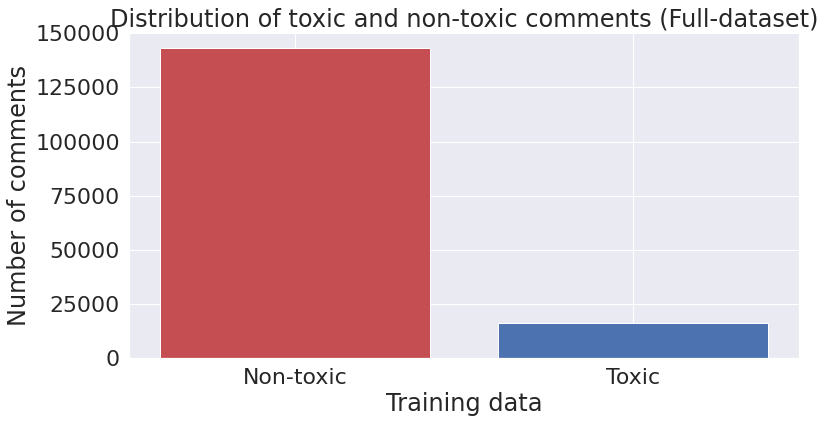

In [ ]:
plt.rcParams["figure.figsize"] = (20,8)
sum_rows = train_df.iloc[:,1:].sum(axis=1)
non_toxic_comments_count = (sum_rows==0).sum(axis=0)
toxic_comments_count = train_df.shape[0]-non_toxic_comments_count
print("Total training examples = ",train_df.shape[0])
print("Total number of non-toxic comments = ",non_toxic_comments_count)
print("Total number of toxic comments =", toxic_comments_count)

vals = ["Non-toxic","Toxic"]
height=[non_toxic_comments_count,toxic_comments_count]
plt.figure(figsize=(12,6))
plt.bar(vals,height,color=["r","b"])
plt.title("Distribution of toxic and non-toxic comments (Full-dataset)")
plt.grid(True)
plt.ylabel("Number of comments")
plt.xlabel("Training data")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


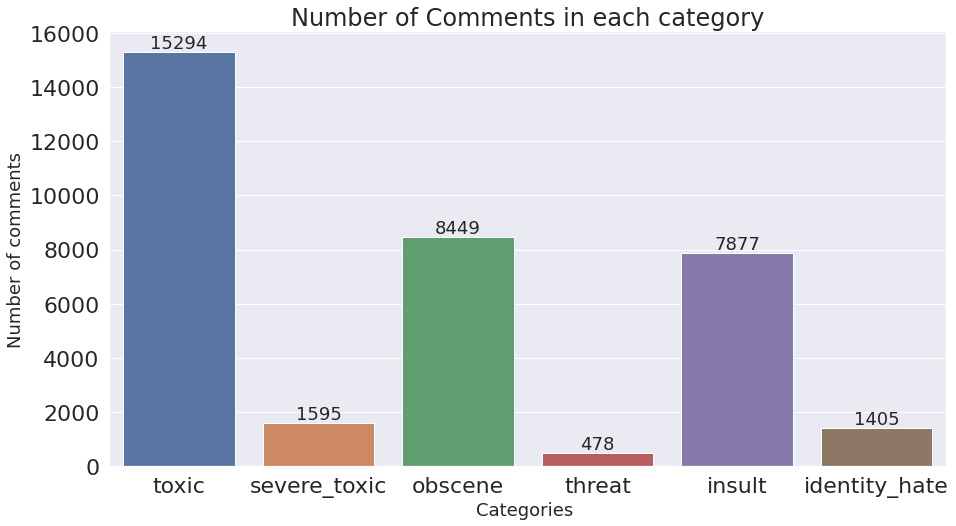

In [ ]:
# comments count in each category
categories=['toxic','severe_toxic','obscene' ,'threat' ,'insult' ,'identity_hate']
comments_count = []
for category in categories:
    comments_count.append((category, train_df[category].sum()))
df_stats = pd.DataFrame(comments_count, columns=['category', 'Number of comments'])
#plotting the stats
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, train_df.iloc[:,1:].sum().values)

plt.title("Number of Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Categories ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = train_df.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

# Dataset rebalancing

##Undersampling method

**Rebalancing the training data**

In [ ]:
rowSums = train_df.iloc[:,1:].sum(axis=1)
rowSums = rowSums.to_list()
train_df["row_sums"] =rowSums

grouped = train_df.groupby(train_df.row_sums)
df_non_toxic = grouped.get_group(0)
mask = train_df["row_sums"]>0
df_toxic = train_df[mask]

df_toxic = df_toxic.drop("row_sums",1)
df_non_toxic_full = df_non_toxic.drop("row_sums",1)


df_non_toxic_sampled = df_non_toxic_full.sample(n=df_toxic.shape[0],random_state=42)

new_train_df_us = df_toxic.append(df_non_toxic_sampled, ignore_index=True)
new_train_df_us = new_train_df_us.sample(frac = 1)
new_train_df_us.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32450 entries, 28563 to 22159
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   comment_text   32450 non-null  object
 1   toxic          32450 non-null  int64 
 2   severe_toxic   32450 non-null  int64 
 3   obscene        32450 non-null  int64 
 4   threat         32450 non-null  int64 
 5   insult         32450 non-null  int64 
 6   identity_hate  32450 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 2.0+ MB


Total training examples(rebalanced) =  32450
Total number of non-toxic comments(rebalanced) =  16225
Total number of toxic comments(rebalanced) = 16225


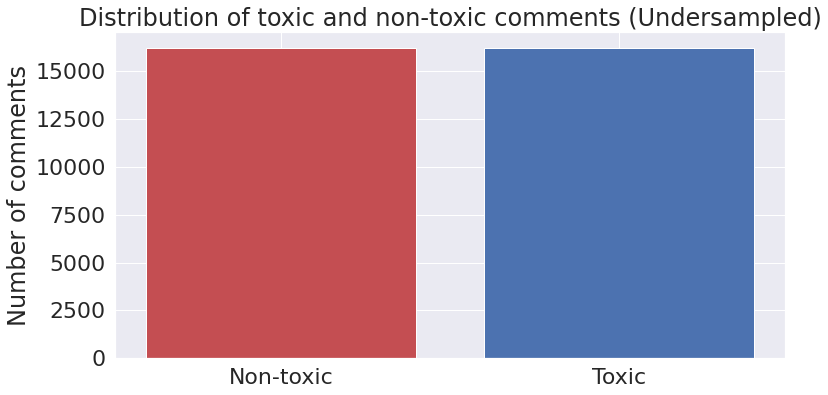

In [ ]:
sum_rows = new_train_df_us.iloc[:,1:].sum(axis=1)
non_toxic_comments_count = (sum_rows==0).sum(axis=0)
toxic_comments_count = new_train_df_us.shape[0]-non_toxic_comments_count
print("Total training examples(rebalanced) = ",new_train_df_us.shape[0])
print("Total number of non-toxic comments(rebalanced) = ",non_toxic_comments_count)
print("Total number of toxic comments(rebalanced) =", toxic_comments_count)

vals = ["Non-toxic","Toxic"]
height=[non_toxic_comments_count,toxic_comments_count]
plt.figure(figsize=(12,6))
plt.bar(vals,height,color=["r","b"])
plt.title("Distribution of toxic and non-toxic comments (Undersampled)")
plt.grid(True)
plt.ylabel("Number of comments")
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


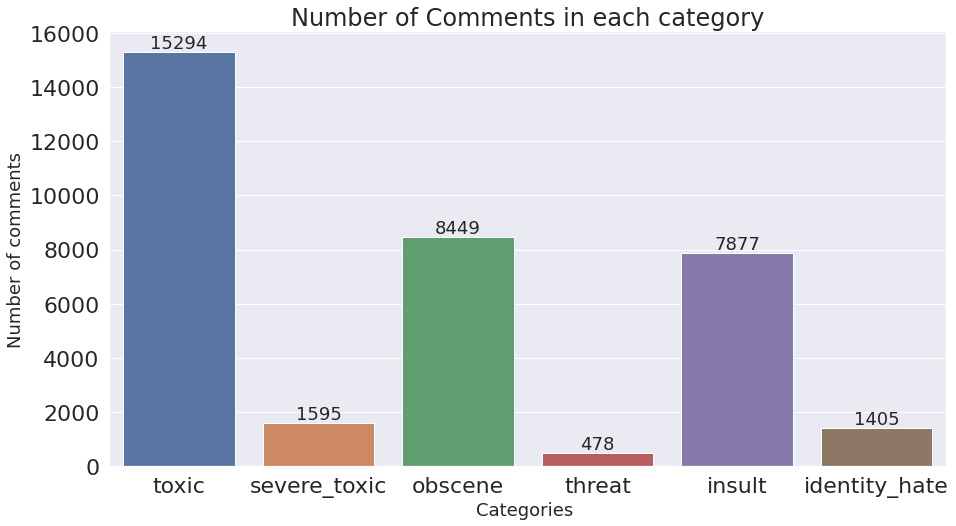

In [ ]:
# comments count in each category
categories=['toxic','severe_toxic','obscene' ,'threat' ,'insult' ,'identity_hate']
comments_count = []
for category in categories:
    comments_count.append((category, new_train_df_us[category].sum()))
df_stats = pd.DataFrame(comments_count, columns=['category', 'Number of comments'])
#plotting the stats
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, new_train_df_us.iloc[:,1:].sum().values)

plt.title("Number of Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Categories ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = new_train_df_us.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

## Oversampling method

**Oversampling - rebalancing the dartaset**

In [ ]:
df_toxic_oversample = df_toxic.sample(df_non_toxic_full.shape[0], replace=True)

# Merge back to single df
new_train_df_os = pd.concat([df_toxic_oversample, df_non_toxic_full], axis=0)

new_train_df_os.info()

<class 'pandas.core.frame.DataFrame'>
Index: 286692 entries, b26006c0ec976c09 to fff46fc426af1f9a
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   286692 non-null  object
 1   toxic          286692 non-null  int64 
 2   severe_toxic   286692 non-null  int64 
 3   obscene        286692 non-null  int64 
 4   threat         286692 non-null  int64 
 5   insult         286692 non-null  int64 
 6   identity_hate  286692 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 17.5+ MB


**splitting and then oversampling**

In [16]:
os_train_df, os_test_df = train_test_split(train_df,test_size=0.25,random_state=43)

In [20]:
print(os_train_df.shape)
print(os_test_df.shape)

(119678, 7)
(39893, 7)


**Plotting the distribution of rebalanced dataframe**

Total training examples(rebalanced) =  286692
Total number of non-toxic comments(rebalanced) =  143346
Total number of toxic comments(rebalanced) = 143346


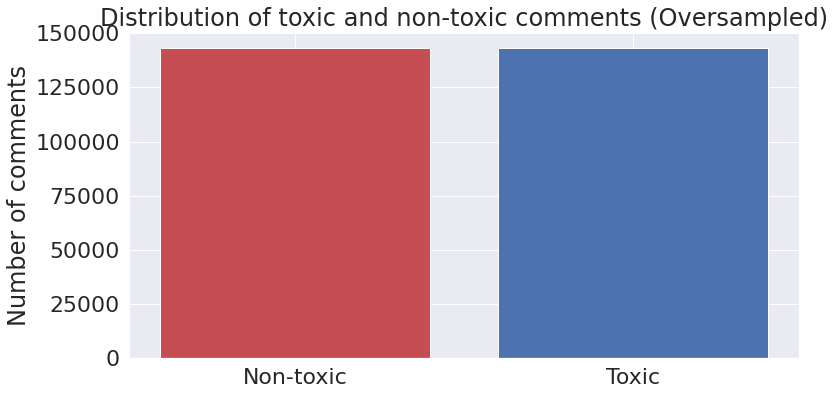

In [ ]:
sum_rows = new_train_df_os.iloc[:,1:].sum(axis=1)
non_toxic_comments_count = (sum_rows==0).sum(axis=0)
toxic_comments_count = new_train_df_os.shape[0]-non_toxic_comments_count
print("Total training examples(rebalanced) = ",new_train_df_os.shape[0])
print("Total number of non-toxic comments(rebalanced) = ",non_toxic_comments_count)
print("Total number of toxic comments(rebalanced) =", toxic_comments_count)

vals = ["Non-toxic","Toxic"]
height=[non_toxic_comments_count,toxic_comments_count]
plt.figure(figsize=(12,6))
plt.bar(vals,height,color=["r","b"])
plt.title("Distribution of toxic and non-toxic comments (Oversampled)")
plt.grid(True)
plt.ylabel("Number of comments")
plt.show()

**Plotting coments count based on categories**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


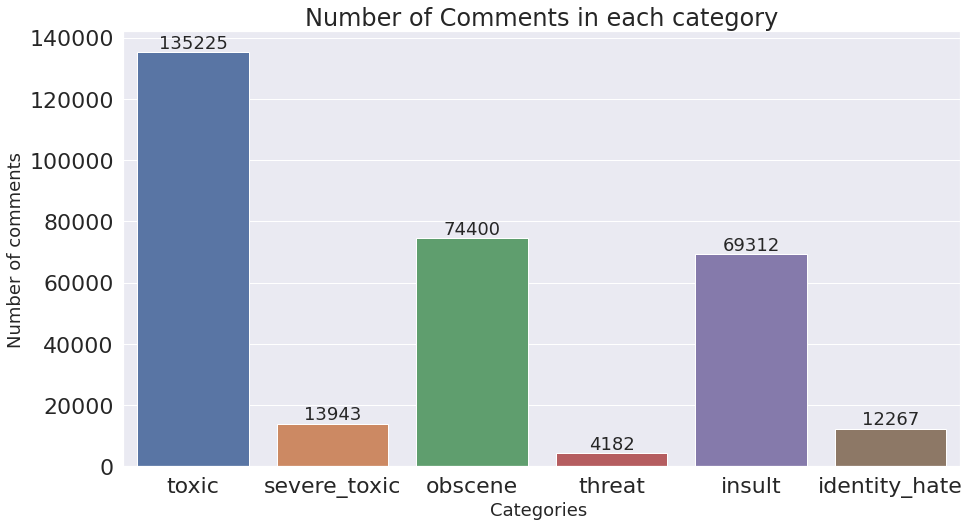

In [ ]:
# comments count in each category
categories=['toxic','severe_toxic','obscene' ,'threat' ,'insult' ,'identity_hate']
comments_count = []
for category in categories:
    comments_count.append((category, new_train_df_os[category].sum()))
df_stats = pd.DataFrame(comments_count, columns=['category', 'Number of comments'])
#plotting the stats
sns.set(font_scale = 2)
plt.figure(figsize=(15,8))
ax= sns.barplot(categories, new_train_df_os.iloc[:,1:].sum().values)

plt.title("Number of Comments in each category", fontsize=24)
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Categories ', fontsize=18)

#adding the text labels
rects = ax.patches
labels = new_train_df_os.iloc[:,1:].sum().values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom', fontsize=18)

plt.show()

**Plotting comments with multiple labels**

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


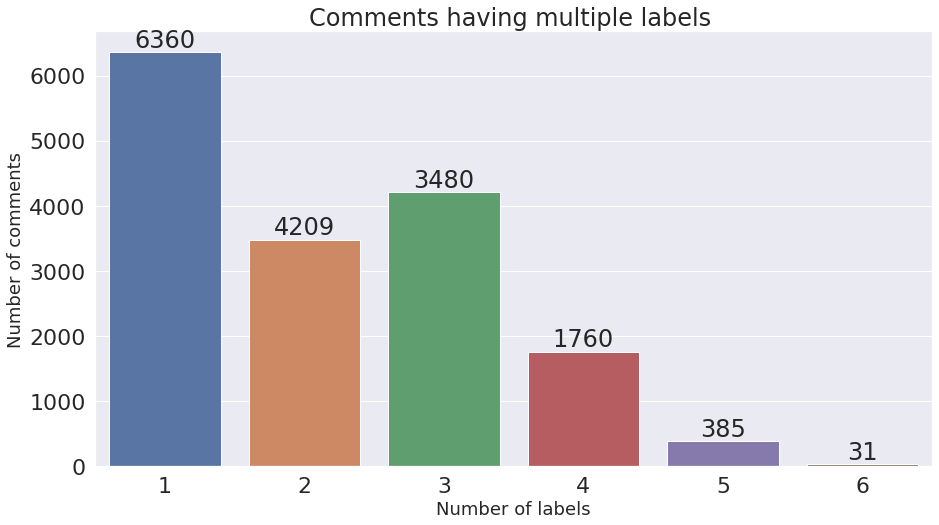

In [ ]:
rowSums = new_train_df.iloc[:,1:].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
multiLabel_counts = multiLabel_counts.iloc[1:]

sns.set(font_scale = 2)
plt.figure(figsize=(15,8))

ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)

plt.title("Comments having multiple labels ")
plt.ylabel('Number of comments', fontsize=18)
plt.xlabel('Number of labels', fontsize=18)

#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()


**Distribution of comments length in rebalanced dataset before preprocessing**

/usr/local/lib/python3.7/dist-packages/IPython/core/pylabtools.py:125: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  fig.canvas.print_figure(bytes_io, **kw)


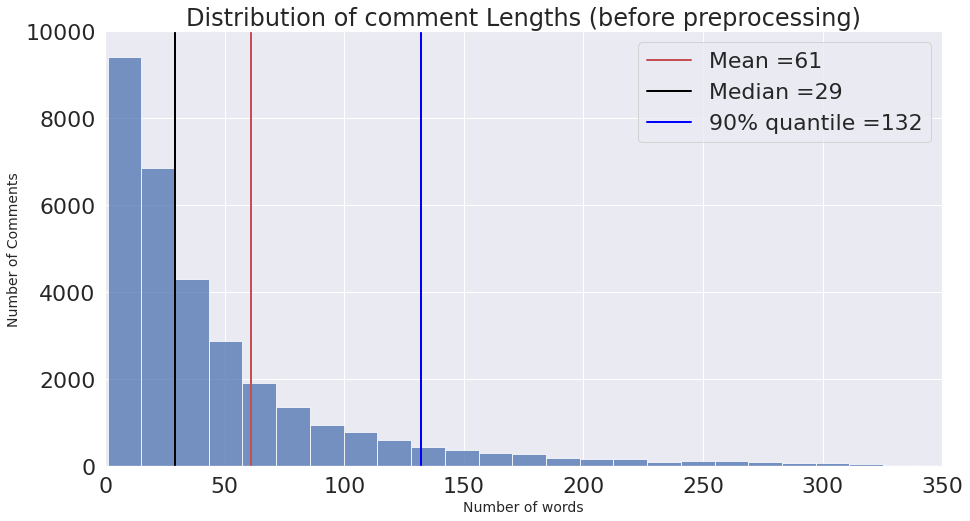

In [ ]:
comments_lengths = [len(comment.split()) for comment in new_train_df["comment_text"]]

plt.figure(figsize=(15,8))

mean=round(np.mean(comments_lengths))
median = round(np.median(comments_lengths))
quantile = round(np.quantile(comments_lengths,0.90))

plt.axvline(mean, color='R', linewidth=2)
plt.axvline(median,color='black',linewidth=2)
plt.axvline(quantile,color="Blue",linewidth=2)
plt.legend(["Mean ="+str(mean),"Median ="+str(median),
                        "90% quantile ="+str(quantile)])
sns.histplot(comments_lengths, bins=100)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Number of Comments", fontsize=14)
plt.axis([0, 350, 0, 10000])
plt.title("Distribution of comment Lengths (before preprocessing)")
plt.show()

# Data preprocessing


In [15]:
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer


class Data_Preprocessing():
    def __init__(self):
        self.stemmer    =   PorterStemmer()
        self.lemmatizer =   WordNetLemmatizer()
        self.morphy_tag =   {'JJ':wordnet.ADJ,'VB':wordnet.VERB,'RB':wordnet.ADV}
        self.stop_words =   set(stopwords.words('english'))

    def remove_urls(self,comment:str):
        """remove urls present in a sentence.

        Args:
            comment (str): sentence to be cleaned

        Returns:
            str: [cleaned sentence.
        """
        return re.sub(r"http\S+", "", comment)
    
    def remove_alphanumeric(self,comment:str):
        """remove special/alphaneumeric characters from a sentence.

        Args:
            comment (str): sentence to be cleaned.

        Returns:
            str: [cleaned sentence.
        """
        return re.sub('[^A-Za-z0-9]+', ' ', comment)

    def convert_lowercase(self,comment:str):
        """convert words in a sentence to lowercase.

        Args:
            comment (str): sentence to be lowercased.

        Returns:
            str: lowercase sentence.
        """
        return str(comment).lower()
    
    def stemm_and_lemmatize(self,comment:str):
        """removes stopwords and perform stemming and lemmatization using pos tagging.

        Args:
            comment (str): sentence to be processed.

        Returns:
            str : processed sentence.
        """
        MIN_WORD_LEN = 2
        words   =   comment.split()
        processed_comment   =   []
        for word in words:
            if word not in self.stop_words:
                pos_tag =   nltk.pos_tag([str(word)])
                word    =   self.stemmer.stem(word)
                if pos_tag[0][1] in self.morphy_tag.keys():
                    word    =   self.lemmatizer.lemmatize(word,\
                                    pos=self.morphy_tag[str(pos_tag[0][1])])
                    processed_comment.append(word)
                else:
                    word    =   self.lemmatizer.lemmatize(word)
                    processed_comment.append(word)

        processed_comment   =   ' '.join([w for w in processed_comment if len(w)>MIN_WORD_LEN])
        return  processed_comment
    
    def split_comment(self,comment:str):
        """Split sentences into words.

        Args:
            comment str: sentence to be splitted into to words.

        Returns:
            list[str]: list of words
        """
        return comment.split()

    def remove_white_spaces(slef,comment:str):
        pass 

    def remove_numbers(self,comment:str):
        processed_comment   =   ''.join(w for w in comment if not w.isdigit())
        return processed_comment
        
    def text_normalize(self,comment:str,tokens=False):
        """ Implement all the preprocessig steps.

        Args:
            comment (str): sentence to be preprocessed.
            tokens (bool, optional): If true returns tokens. Defaults to False.
        Returns:
            list: tokenized words. Default to False.
            str : preprocessed sentence.
        """
        comment =   self.remove_urls(comment)
        comment =   self.remove_alphanumeric(comment)
        comment =   self.convert_lowercase(comment)
        comment =   self.remove_numbers(comment)
        comment =   self.stemm_and_lemmatize(comment)
        words  =   self.split_comment(comment)
        if  tokens  ==  True:
            return words
        elif    tokens  ==  False:
            return  comment


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


**preprocessing entire dataset**

In [ ]:
%%time
pp = Data_Preprocessing()
test_oversample['preprocessed_text'] = test_oversample['comment_text'].apply(pp.text_normalize)

CPU times: user 26min 22s, sys: 1min 5s, total: 27min 28s
Wall time: 27min 25s


In [34]:
%%time
pp = Data_Preprocessing()
os_new_train_df['preprocessed_text'] = os_new_train_df['comment_text'].apply(pp.text_normalize)
#os_test_df['preprocessed_text'] = os_test_df['comment_text'].apply(pp.text_normalize)

CPU times: user 20min 6s, sys: 52.6 s, total: 20min 59s
Wall time: 20min 56s


Total training examples(rebalanced) =  39893
Total number of non-toxic comments(rebalanced) =  35875
Total number of toxic comments(rebalanced) = 4018


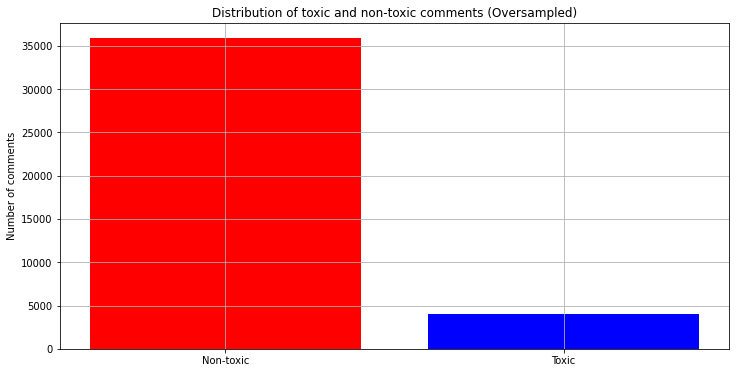

In [27]:
sum_rows = os_test_df.iloc[:,1:].sum(axis=1)
non_toxic_comments_count = (sum_rows==0).sum(axis=0)
toxic_comments_count = os_test_df.shape[0]-non_toxic_comments_count
print("Total training examples(rebalanced) = ",os_test_df.shape[0])
print("Total number of non-toxic comments(rebalanced) = ",non_toxic_comments_count)
print("Total number of toxic comments(rebalanced) =", toxic_comments_count)

vals = ["Non-toxic","Toxic"]
height=[non_toxic_comments_count,toxic_comments_count]
plt.figure(figsize=(12,6))
plt.bar(vals,height,color=["r","b"])
plt.title("Distribution of toxic and non-toxic comments (Oversampled)")
plt.grid(True)
plt.ylabel("Number of comments")
plt.show()

In [29]:
#splitting toxic and non-toxic 
rowSums = os_train_df.iloc[:,1:].sum(axis=1)
rowSums = rowSums.to_list()
os_train_df["row_sums"] =rowSums

grouped = os_train_df.groupby(os_train_df.row_sums)
os_df_non_toxic = grouped.get_group(0)
mask = os_train_df["row_sums"]>0
os_df_toxic = os_train_df[mask]

os_df_toxic = os_df_toxic.drop("row_sums",1)
os_df_non_toxic_full = os_df_non_toxic.drop("row_sums",1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


**oversampling**

<class 'pandas.core.frame.DataFrame'>
Index: 214942 entries, ddca58663b692e99 to 6cc36bb4d5aacc63
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   comment_text       214942 non-null  object
 1   toxic              214942 non-null  int64 
 2   severe_toxic       214942 non-null  int64 
 3   obscene            214942 non-null  int64 
 4   threat             214942 non-null  int64 
 5   insult             214942 non-null  int64 
 6   identity_hate      214942 non-null  int64 
 7   preprocessed_text  214942 non-null  object
dtypes: int64(6), object(2)
memory usage: 14.8+ MB
Total training examples(rebalanced) =  214942
Total number of non-toxic comments(rebalanced) =  107471
Total number of toxic comments(rebalanced) = 107471


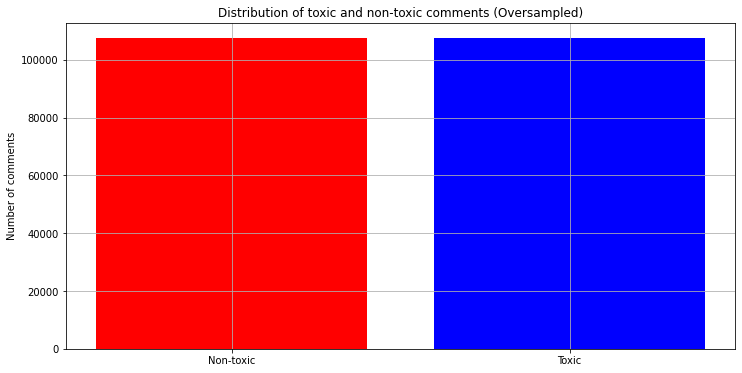

In [33]:
#for training data

os_train_df_oversample = os_df_toxic.sample(os_df_non_toxic_full.shape[0], replace=True)

# Merge back to single df
os_new_train_df = pd.concat([os_train_df_oversample, os_df_non_toxic_full], axis=0)

os_new_train_df.info()

sum_rows = os_new_train_df.iloc[:,1:].sum(axis=1)
non_toxic_comments_count = (sum_rows==0).sum(axis=0)
toxic_comments_count = os_new_train_df.shape[0]-non_toxic_comments_count
print("Total training examples(rebalanced) = ",os_new_train_df.shape[0])
print("Total number of non-toxic comments(rebalanced) = ",non_toxic_comments_count)
print("Total number of toxic comments(rebalanced) =", toxic_comments_count)

vals = ["Non-toxic","Toxic"]
height=[non_toxic_comments_count,toxic_comments_count]
plt.figure(figsize=(12,6))
plt.bar(vals,height,color=["r","b"])
plt.title("Distribution of toxic and non-toxic comments (Oversampled)")
plt.grid(True)
plt.ylabel("Number of comments")
plt.show()

In [ ]:
new_train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,preprocessed_text
2441,Last warning\n\nNow I will give you a warning ...,1,0,1,0,1,1,last warn give warn peasant ukrainian peac shi...
31218,Our next president \n\nI just want to tell peo...,0,0,0,0,0,0,next presid want tell peopl ahead time becom p...
3674,"""\n\n FCUK YOU DOC \n\n The Anti-Vandalism Ba...",1,0,1,0,1,0,fcuk doc anti vandal barnstarfuku
19113,"New Photographs\nHey Matt, I just want to take...",0,0,0,0,0,0,new photograph hey matt want take time comment...
23089,"Vandalislisilisilism=\n\nGee, Thanks!",0,0,0,0,0,0,vandalislisilisil gee thank


In [ ]:
train_df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,preprocessed_text
id,,,,,,,,
0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,explan edit made usernam hardcor metallica fan...
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,aww match background colour seemingli stuck th...
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,hey man realli tri edit war guy constantli rem...
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,make real suggest improv wonder section statis...
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,sir hero chanc rememb page


**Distribution of comment lengts in rebalanced dataset after preprocesing**

In [ ]:
comments_lengths = [len(comment.split()) for comment in new_train_df["preprocessed_text"]]

plt.figure(figsize=(15,8))

mean=round(np.mean(comments_lengths))
median = round(np.median(comments_lengths))
quantile = round(np.quantile(comments_lengths,0.90))

plt.axvline(mean, color='R', linewidth=2)
plt.axvline(median,color='black',linewidth=2)
plt.axvline(quantile,color="Blue",linewidth=2)
plt.legend(["Mean ="+str(mean),"Median ="+str(median),
                        "90% quantile ="+str(quantile)])
sns.histplot(comments_lengths, bins=100)
plt.xlabel("Number of words", fontsize=14)
plt.ylabel("Number of Comments", fontsize=14)
plt.axis([0, 250, 0, 15000])
plt.title("Distribution of comment Lengths (after preprocessing)")
plt.show()

**Most used toxic words using WordCloud representation**

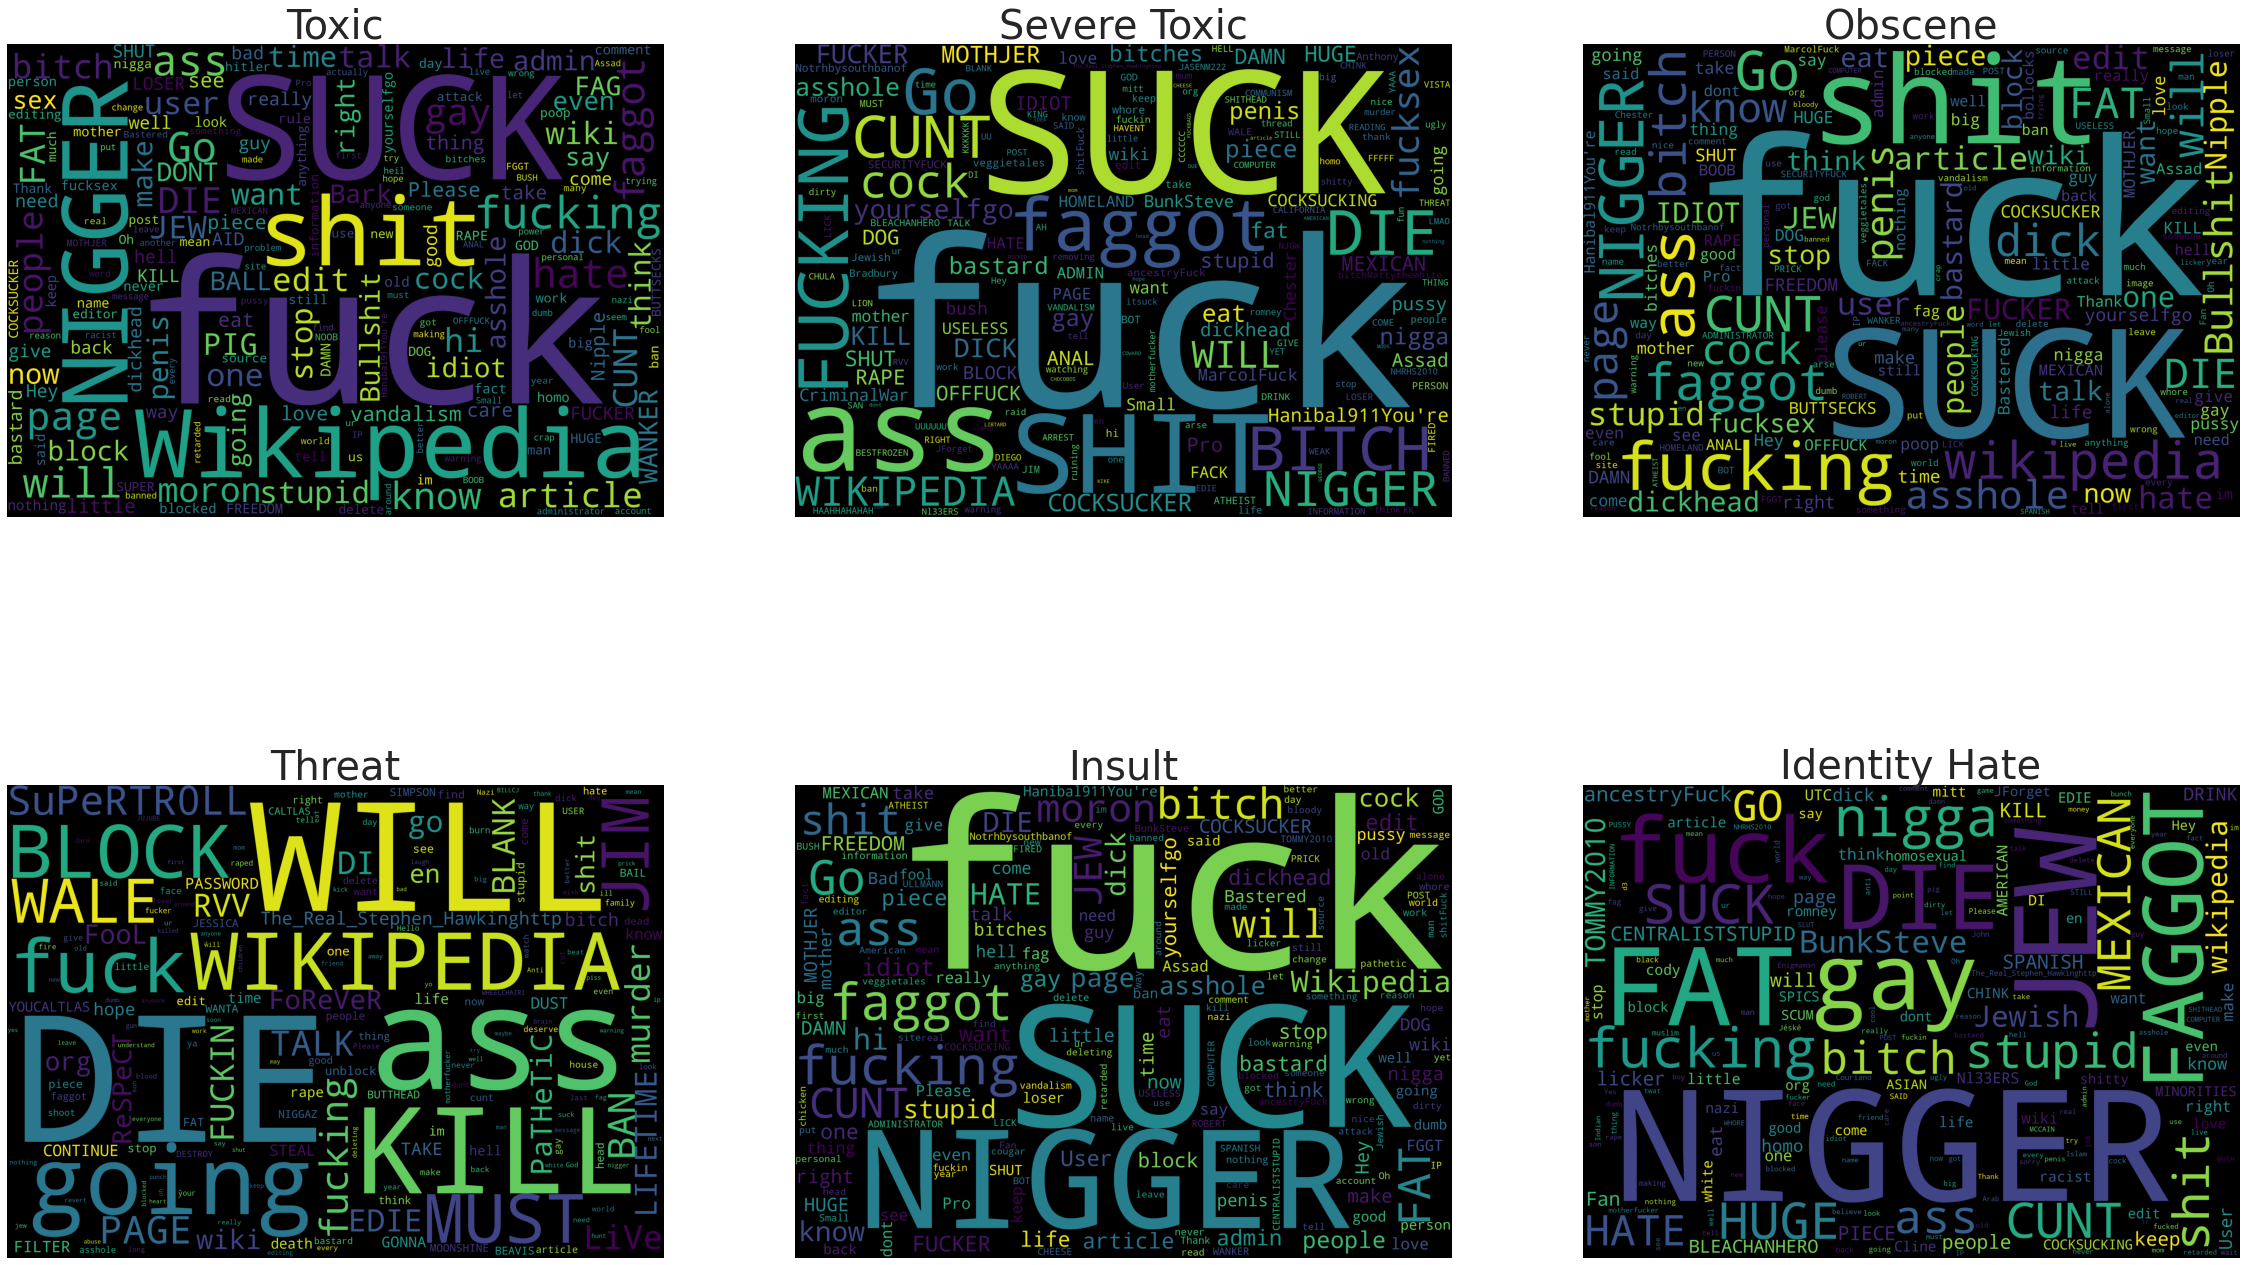

CPU times: user 1min 28s, sys: 1.68 s, total: 1min 30s
Wall time: 1min 30s


In [ ]:
%%time
from wordcloud import WordCloud,STOPWORDS

plt.figure(figsize=(40,25))

# toxic
subset = new_train_df[new_train_df.toxic==1]
text = subset.comment_text.values
cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 1)
plt.axis('off')
plt.title("Toxic",fontsize=40)
plt.imshow(cloud_toxic)


# severe_toxic
subset = new_train_df[new_train_df.severe_toxic==1]
text = subset.comment_text.values
cloud_severe_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 2)
plt.axis('off')
plt.title("Severe Toxic",fontsize=40)
plt.imshow(cloud_severe_toxic)


# obscene
subset = new_train_df[new_train_df.obscene==1]
text = subset.comment_text.values
cloud_obscene = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 3)
plt.axis('off')
plt.title("Obscene",fontsize=40)
plt.imshow(cloud_obscene)


# threat
subset = new_train_df[new_train_df.threat==1]
text = subset.comment_text.values
cloud_threat = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 4)
plt.axis('off')
plt.title("Threat",fontsize=40)
plt.imshow(cloud_threat)


# insult
subset = new_train_df[new_train_df.insult==1]
text = subset.comment_text.values
cloud_insult = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 5)
plt.axis('off')
plt.title("Insult",fontsize=40)
plt.imshow(cloud_insult)


# identity_hate
subset = new_train_df[new_train_df.identity_hate==1]
text = subset.comment_text.values
cloud_identity_hate = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))

plt.subplot(2, 3, 6)
plt.axis('off')
plt.title("Identity Hate",fontsize=40)
plt.imshow(cloud_identity_hate)

plt.show()

**Correlation between the target labels**

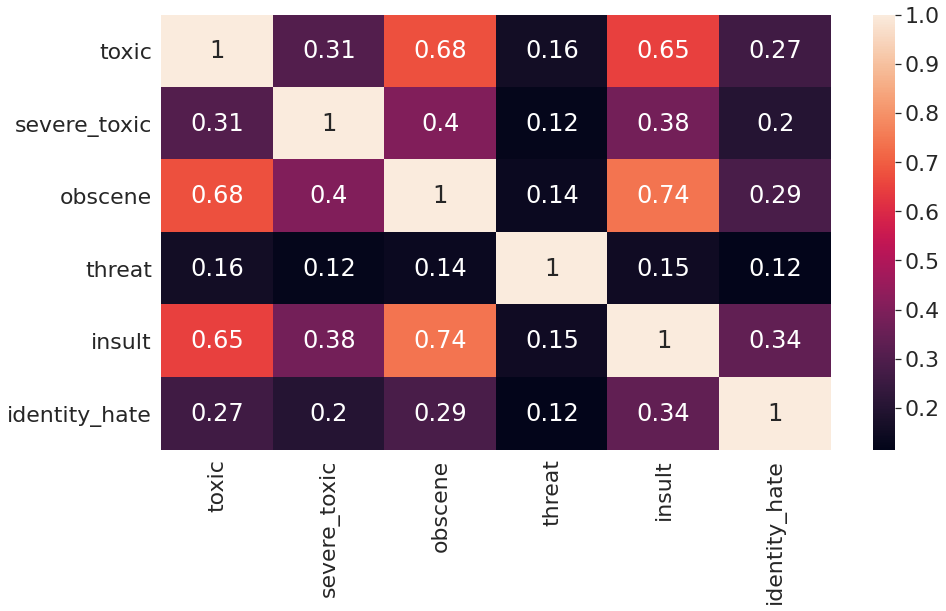

In [ ]:
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
labels_cor = train_df[labels].corr()
plt.figure(figsize=(15,8))
sns.heatmap(labels_cor, annot=True)

In [35]:
feature = os_new_train_df[["preprocessed_text"]]
labels = os_new_train_df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

In [ ]:
seed =42
X_train, X_test, y_train, y_test = train_test_split(feature, labels,test_size = 0.20,random_state=seed)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(127656, 1)
(31915, 1)
(127656, 6)
(31915, 6)


In [36]:
# X_train = feature
# #X_test = os_test_df[["preprocessed_text"]]
# y_train = labels
# #y_test = os_test_df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']]

In [37]:
X_train.to_pickle('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/X_train.pkl')
#X_test.to_pickle('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/X_test.pkl')
y_train.to_pickle('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/y_train.pkl')
#y_test.to_pickle('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/y_test.pkl')

In [46]:
X_train = pd.read_pickle('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/pkls_us/X_train_us.pkl')
X_test = pd.read_pickle('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/pkls_us/X_test_us.pkl')
y_test =pd.read_pickle('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/pkls_us/y_test_us.pkl')
y_train = pd.read_pickle('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/pkls_us/y_train_us.pkl')

#Bag Of Words - TFIDF

In [9]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer

# tfdif vectorizer with 1 and 2 ngrams
tfidf_vec = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3),max_features=1000, norm='l2')
tfidf_vec.fit_transform(X_train["preprocessed_text"])
#tfidf_vec.fit_transform(X_test["preprocessed_text"])

CPU times: user 42.1 s, sys: 1.5 s, total: 43.6 s
Wall time: 43.5 s


In [53]:
# import pickle
# with open('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/pkls/LSTM_vectorizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

In [63]:
%%time
# trasform train and test
train_tfidf = tfidf_vec.transform(X_train["preprocessed_text"])
test_tfidf = tfidf_vec.transform(X_test["preprocessed_text"])

print(train_tfidf[0])
print(test_tfidf.shape)

  (0, 660)	0.445510506328906
  (0, 535)	0.6639154171054125
  (0, 12)	0.6006136093032758
(6490, 1000)
CPU times: user 2.32 s, sys: 6.93 ms, total: 2.33 s
Wall time: 2.34 s


In [64]:
# # now you can save it to a file
# with open('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/LR_us_vectorizer.pkl', 'wb') as f:
#     pickle.dump(tfidf_vec, f)


In [120]:
# with open('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/pkls/LR_vectorizer.pkl', 'rb') as fin:
#   vectorizer = pickle.load(fin)

# with open('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/pkls/LR.pkl', 'rb') as fin:
#   clf = pickle.load(fin)

# toxic_comment   =   str(input("Enter a comment : "))
# tfidf_vec   =   vectorizer.transform([toxic_comment])
# predicted_labels= clf.predict(tfidf_vec).todense().tolist()

# predictions=[]
# for idx,val in enumerate(predicted_labels[0]):
#   labels = [{'1':'toxic','0':0},{'1':'severe_toxic','0':0},{'1':'obscene','0':0},\
#             {'1':'threat','0':0},{'1':'insult','0':0},\
#               {'1':'identity_hate','0':0}]
#   predictions.append(labels[idx][str(val)])

# predictions = [x for x in predictions if x !=0]
# print("the comment is :",predictions)

Enter a comment : go die nigger
the comment is : ['toxic', 'obscene', 'insult', 'identity_hate']


In [43]:
pip install scikit-multilearn

     |████████████████████████████████| 92kB 5.5MB/s 


In [52]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, log_loss, hamming_loss, accuracy_score


In [55]:
# evaluation function
def eval_fun_br(x_test, y_test, classifier):
    y_labels = classifier.predict(x_test).todense()
    y_pred = classifier.predict_proba(x_test).todense()

    # accuracy score as the average of accuracy for individual labels
    accuracy = np.mean([accuracy_score(y_test.iloc[:,i], y_labels[:,i]) for i in range (6)])

    # auc as the average of auc for individual labels
    auc = np.mean([roc_auc_score(y_test.iloc[:,i], y_pred[:,i]) for i in range (6)])

    # logloss as the average of logloss for individual labels
    logloss = np.mean([log_loss(y_test.iloc[:,i], y_pred[:,i]) for i in range(6)])

    return pd.DataFrame({'Model':'BR-' + type(classifier.classifier).__name__,
                        "Accuracy": np.round(accuracy,3),
                        "AUC": np.round(auc,3) ,
                        "Log loss": np.round(logloss,3)}, index = [0])

In [65]:
%%time
# Logistic Regression
lr_clf = BinaryRelevance(LogisticRegression( solver='liblinear'))
lr_clf.fit(train_tfidf, y_train)

CPU times: user 1.6 s, sys: 61 ms, total: 1.66 s
Wall time: 1.67 s


In [66]:
# evaluation
lr_eval = eval_fun_br(x_test=test_tfidf, y_test=y_test, classifier=lr_clf)
lr_eval

,Model,Accuracy,AUC,Log loss
0,BR-LogisticRegression,0.92,0.927,0.199


In [67]:
import pickle
# now you can save it to a file
with open('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/LR_us.pkl', 'wb') as f:
    pickle.dump(lr_clf, f)


#Classification using LSTM

In [47]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Dense, Bidirectional, Embedding, LSTM, BatchNormalization, Dropout

#import texthero as hero
#from texthero import preprocessing, wordcloud



In [48]:

# tokenizing the text
VOCAB_SIZE = 10000
tokenizer = Tokenizer(num_words=VOCAB_SIZE)

tokenizer.fit_on_texts(X_train["preprocessed_text"])
#tokenizer.fit_on_texts(X_test["preprocessed_text"])

train_sequences = tokenizer.texts_to_sequences(X_train["preprocessed_text"])
test_sequences = tokenizer.texts_to_sequences(X_test["preprocessed_text"])

In [49]:
# import pickle
# with open('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/pkls_us/LSTM_vectorizer_us.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

/usr/local/lib/python3.7/dist-packages/google/colab/_event_manager.py:28: MatplotlibDeprecationWarning: Support for uppercase single-letter colors is deprecated since Matplotlib 3.1 and will be removed in 3.3; please use lowercase instead.
  func(*args, **kwargs)


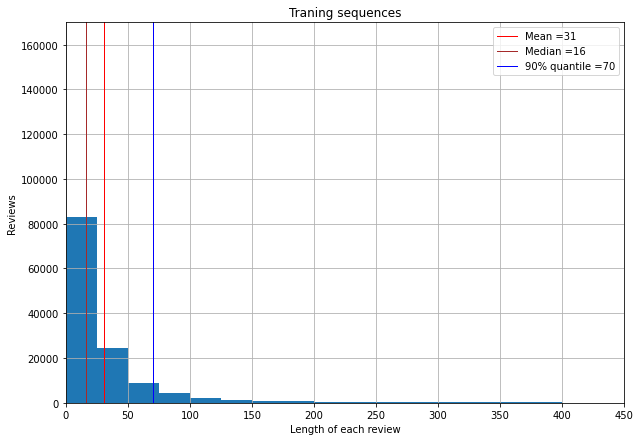

In [18]:
def plot_data(sequences,title):
    len_texts = [len(review) for review in sequences]
    mean=round(np.mean(len_texts))
    median = round(np.median(len_texts))
    quantile = round(np.quantile(len_texts,0.90))

    plt.figure(figsize=(10,7))
    plt.hist(len_texts,bins=50)
    plt.axvline(mean, color='R', linewidth=1)
    plt.axvline(median,color='brown',linewidth=1)
    plt.axvline(quantile,color="Blue",linewidth=1)
    plt.legend(["Mean ="+str(mean),"Median ="+str(median),
                        "90% quantile ="+str(quantile)])
    plt.title(str(title))
    plt.axis([0, 450, 0, 170000])
    plt.grid(True)
    plt.ylabel("Reviews")
    plt.xlabel("Length of each review")
    return quantile
    
quantile_train=plot_data(train_sequences,"Traning sequences")

In [19]:
PAD_LENGTH = quantile_train
train_padded = pad_sequences(train_sequences, maxlen = PAD_LENGTH,padding='post',truncating='post')
test_padded = pad_sequences(test_sequences, maxlen = PAD_LENGTH,padding='post',truncating='post')

In [79]:
# create the model
model = Sequential()
model.add(Input(shape=(None,)))

# Embedding layer
model.add(Embedding(input_dim=VOCAB_SIZE+1, output_dim=300, 
                    input_length=PAD_LENGTH, mask_zero=True))

# LSTM layer
model.add(LSTM(units= 50, dropout=0.4, return_sequences=False))
# Dense layer
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(6, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         3000300   
_________________________________________________________________
lstm (LSTM)                  (None, 50)                70200     
_________________________________________________________________
dense (Dense)                (None, 512)               26112     
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3078      
Total params: 3,101,738
Trainable params: 3,100,714
Non-trainable params: 1,024
__________________________________________

In [82]:
# compile the model
model.compile(tf.keras.optimizers.Adam(lr = 5e-4),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.metrics.BinaryAccuracy(),tf.metrics.AUC(multi_label=True, name='auc')])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [83]:
callbacks = [tf.keras.callbacks.ModelCheckpoint('best_lstm_model', save_best_only=True),
             tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, factor=0.2),
              tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4)]


In [50]:
lstm_history = model.fit(train_padded, y_train,
                         validation_data = (test_padded, y_test),
                         batch_size=32,
                         epochs = 50, callbacks = callbacks)


In [ ]:
model.save('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/lstm_toxic_cmnts_us_2')

INFO:tensorflow:Assets written to: drive/MyDrive/jigsaw-toxic-comment-classification-challenge/lstm_toxic_cmnts_us_2/assets


INFO:tensorflow:Assets written to: drive/MyDrive/jigsaw-toxic-comment-classification-challenge/lstm_toxic_cmnts_us_2/assets


In [ ]:
model.save_weights()

In [ ]:
best_model = tf.keras.models.load_model('best_lstm_model')

In [ ]:
# evaluation
loss, accuracy, auc = best_model.evaluate(test_padded, y_test)

print(f'Accuracy : {np.round(accuracy,4)}')
print(f'Auc : {np.round(auc,4)}')
print(f'Logloss : {np.round(loss,4)}')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


998/998 [==============================] - 8s 6ms/step - loss: 0.0506 - binary_accuracy: 0.9817 - auc: 0.9660
Accuracy : 0.9817
Auc : 0.966
Logloss : 0.0506


In [15]:
my_model = tf.keras.models.load_model('drive/MyDrive/jigsaw-toxic-comment-classification-challenge/lstm_toxic_cmnts')

In [20]:
# evaluation
loss, accuracy, auc = my_model.evaluate(test_padded, y_test)

print(f'Accuracy : {np.round(accuracy,4)}')
print(f'Auc : {np.round(auc,4)}')
print(f'Logloss : {np.round(loss,4)}')

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


998/998 [==============================] - 24s 21ms/step - loss: 0.0615 - binary_accuracy: 0.9806 - auc: 0.9433
Accuracy : 0.9806
Auc : 0.9433
Logloss : 0.0615


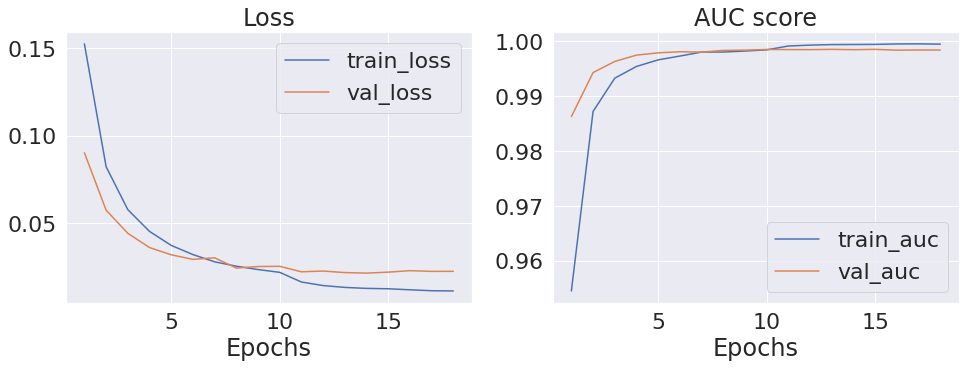

In [ ]:
# performance curve
fig, ax = plt.subplots(1,2, figsize = (16,5))
epochs = [i for i in range(1,19)]
ax[0].plot(epochs, lstm_history.history['loss'], label = 'train_loss');
ax[0].plot(epochs, lstm_history.history['val_loss'], label = 'val_loss');
ax[0].set_title("Loss");
ax[0].set_xlabel("Epochs")
ax[0].legend();

ax[1].plot(epochs, lstm_history.history['auc'], label = 'train_auc');
ax[1].plot(epochs, lstm_history.history['val_auc'], label = 'val_auc');
ax[1].set_title("AUC score");
ax[1].set_xlabel("Epochs")
ax[1].legend();